In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoLarsCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from scipy.stats import gmean
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import DMatrix

/home/lttviet/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lttviet/scikit-learn/sklearn/grid_search.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 8

In [3]:
df = pd.read_csv("processed.csv", header=0, index_col="ID")
df.TARGET.describe()

count    76020.000000
mean         0.039569
std          0.194945
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TARGET, dtype: float64

In [12]:
print( df.TARGET[df.TARGET == 1].shape )
print( df.TARGET[df.TARGET == 0].shape)

(3008,)
(73012,)


In [4]:
y = df["TARGET"].values
X = df.ix[:, "var3":"var38"].values
X_labels = df.ix[:, "var3":"var38"].columns.values

In [5]:
lr = LassoLarsCV()
sfm = SelectFromModel(lr, threshold=1e-3)
X_std = StandardScaler().fit_transform(X, y)
sfm.fit(X_std,y)
lr.fit(X_std, y)

/home/lttviet/scikit-learn/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 90 iterations, i.e. alpha=1.665e-06, with an active set of 80 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/home/lttviet/scikit-learn/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 114 iterations, i.e. alpha=1.026e-06, with an active set of 98 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/home/lttviet/scikit-learn/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 114 iterations, i.e. alpha=1.026e-06, with an active set of 98 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/home/lttviet/scikit-learn/sklearn/linear_model/least_angle.py:309: ConvergenceWarn

LassoLarsCV(copy_X=True, cv=None, eps=2.2204460492503131e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False)

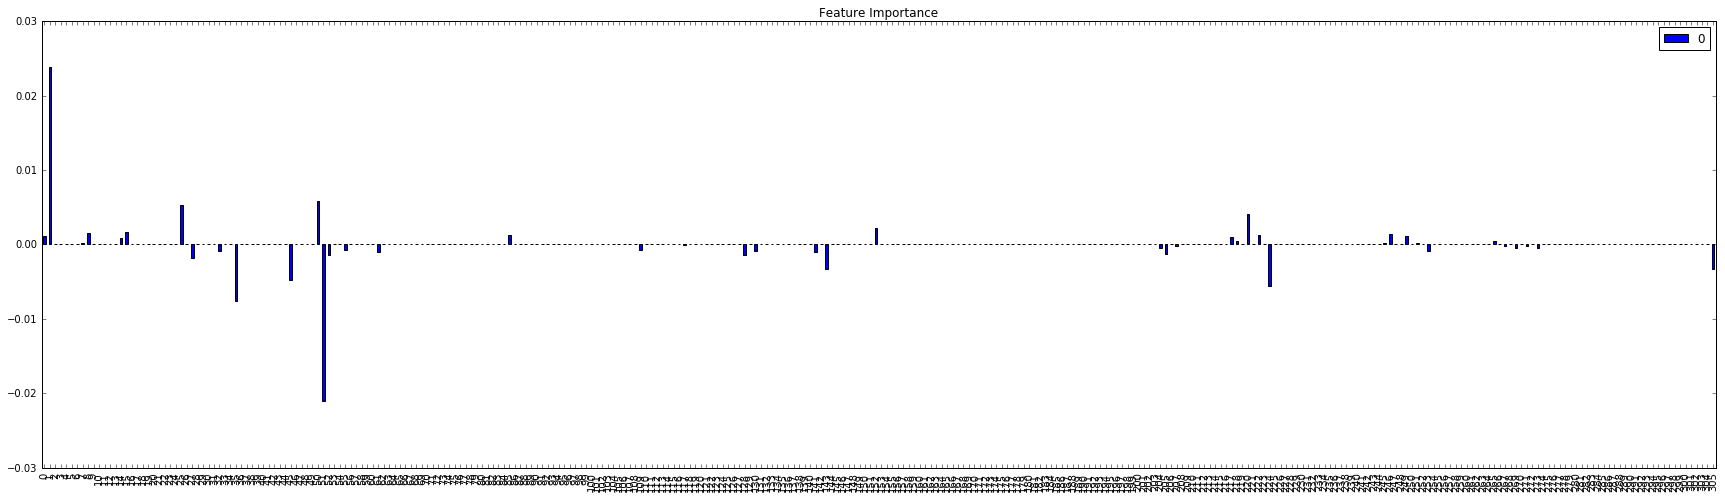

In [6]:
feat_imp = pd.DataFrame(lr.coef_, index=X_labels)
feat_imp.plot(kind="bar", title="Feature Importance", use_index=False)

In [5]:
chosen_feat = [ f for i,f in enumerate(X_labels) if sfm.get_support()[i] ]
#chosen_feat = pickle.load(open("feat", "rb"))
print(len(chosen_feat))
chosen_feat

23


['var3',
 'var15',
 'imp_op_var40_efect_ult3',
 'imp_op_var39_efect_ult1',
 'ind_var8_0',
 'ind_var12_0',
 'ind_var13',
 'ind_var24',
 'ind_var30_0',
 'ind_var30',
 'ind_var31_0',
 'num_var14_0',
 'saldo_var5',
 'saldo_var26',
 'saldo_var30',
 'var36',
 'ind_var43_recib_ult1',
 'num_var22_ult1',
 'num_med_var22_ult3',
 'num_meses_var5_ult3',
 'num_op_var39_efect_ult3',
 'num_reemb_var17_ult1',
 'var38']

In [6]:
# kaggle forum
df.var3 = df.var3.replace(-999999,2)
y = df["TARGET"].values
X = df.ix[:, "var3":"var38"].values
X_labels = df.ix[:, "var3":"var38"].columns.values

In [7]:
test = pd.read_csv("processed_test.csv", header=0, index_col="ID")
test.var3 = test.var3.replace(-999999,2)

X_test = test[chosen_feat].values

In [8]:
X_sel = df[chosen_feat].values

In [9]:
stage2_train = pd.DataFrame(index=df.index)
stage2_test = pd.DataFrame(index=test.index)

In [19]:
# Linear model
logmodel = Pipeline([
        ("scl", StandardScaler()),
        ("clf", LogisticRegressionCV(penalty="l2", cv=5, max_iter=500, scoring="roc_auc", 
                                     n_jobs=-1 ,random_state=1))
    ])

logmodel.fit(X_sel,y)
#logmodel = pickle.load(open("logmodel.p", "rb"))
temp = logmodel.predict_proba(X_sel)[:,1]

In [11]:
s = cross_val_score(logmodel, X_sel, y, scoring="roc_auc", cv=5) 
print(s)
print( "AUC score", gmean(s) )

[ 0.78784072  0.77956982  0.80282835  0.79958595  0.79435441]
AUC score 0.792791748658


In [12]:
stage2_train["LogModel"] = pd.DataFrame(temp, index=df.index)

In [13]:
stage2_test["LogModel"] = logmodel.predict_proba(X_test)[:,1]

In [18]:
xgbc = xgb.XGBClassifier(max_depth=5, n_estimators=200, learning_rate=0.03, nthread=4, 
                          subsample=0.6815, colsample_bytree=0.701, seed=1234)
xgbc.fit(X, y, eval_metric="auc", verbose=2)
#xgbc = pickle.load( open("xgbc.p", "rb") )
temp = xgbc.predict_proba(X_sel)[:, 1]

In [15]:
s = cross_val_score(xgbc, X_sel, y, scoring="roc_auc", cv=5) 
print(s)
print( "AUC score", gmean(s) )

[ 0.83491827  0.82612263  0.84021155  0.85126094  0.83288542]
AUC score 0.837037701123


In [16]:
stage2_train["XGBoost1"] = pd.DataFrame(temp, index=df.index)

In [17]:
stage2_test["XGBoost1"] = xgbc.predict_proba(X_test)[:,1]

In [20]:
xgbc2 = xgb.XGBClassifier(max_depth=5, n_estimators=70, learning_rate=0.1, nthread=4, gamma=0.2,
                          subsample=0.4, colsample_bytree=0.7, min_child_weight=1, seed=1)

xgbc2.fit(X_sel, y, eval_metric="auc", verbose=0)
#xgbc2 = pickle.load(open("xgbc2.p", "rb"))
temp = xgbc2.predict_proba(X_sel)[:, 1]

In [21]:
s = cross_val_score(xgbc2, X_sel, y, scoring="roc_auc", cv=5) 
print(s)
print( "AUC score", gmean(s) )

[ 0.83199204  0.82594466  0.84007561  0.85046797  0.83132755]
AUC score 0.835918095692


In [22]:
stage2_train["XGBoost2"] = pd.DataFrame(temp, index=df.index)

In [23]:
stage2_test["XGBoost2"] = xgbc2.predict_proba(X_test)[:,1]

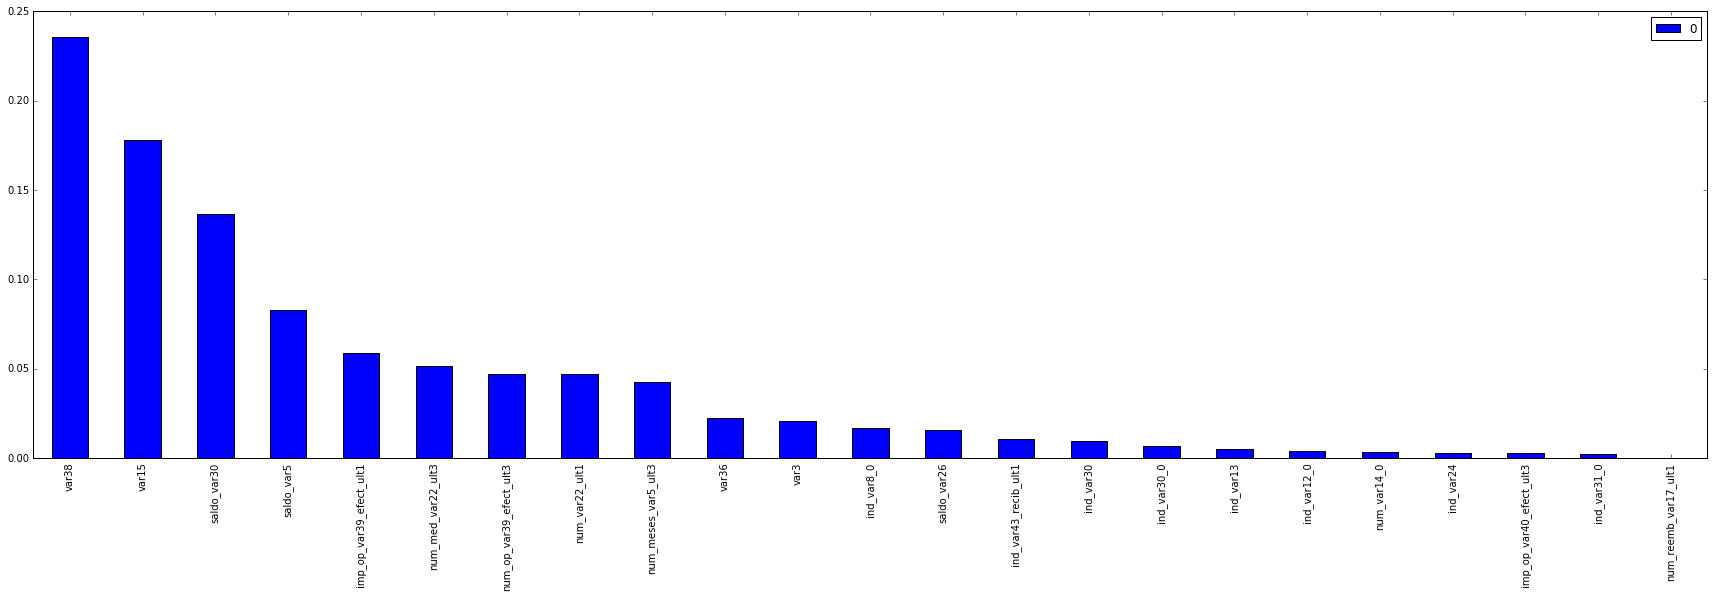

In [26]:
x = pd.DataFrame(xgbc2.feature_importances_, index=chosen_feat)
x.sort_values(by=0, inplace=True, ascending=False)
x.plot(kind="bar")

In [27]:
rfc = RandomForestClassifier(n_estimators=10, criterion="entropy", max_features=None, max_depth=7,
                             min_samples_leaf=9, n_jobs=4, random_state=1)
rfc.fit(X_sel, y)
#rfc = pickle.load( open("rfc.p", "rb"))
temp = rfc.predict_proba(X_sel)[:, 1]

In [28]:
s = cross_val_score(rfc, X_sel, y, scoring="roc_auc", cv=5) 
print(s)
print( "AUC score", gmean(s) )

[ 0.83097941  0.8220707   0.83359297  0.84582492  0.82486153]
AUC score 0.831424851416


In [29]:
stage2_train["RandomForest"] = pd.DataFrame(temp, index=df.index)

In [30]:
stage2_test["RandomForest"] = rfc.predict_proba(X_test)[:,1]

In [31]:
temp = pd.read_csv("simplexgbtrain.csv", header=0, index_col="ID")
stage2_train["XGBoost3"] = temp.PREDICTION.values

In [32]:
temp = pd.read_csv("simplexgbtest.csv", header=0, index_col="ID")
stage2_test["XGBoost3"] = temp.TARGET.values

In [33]:
temp = pd.read_csv("trainR1.csv", header=0)
stage2_train["XGBoostR1"] = temp.TARGET.values

In [34]:
temp = pd.read_csv("testR1.csv", header=0, index_col="ID")
stage2_test["XGBoostR1"] = temp.TARGET.values

In [35]:
stage2_train

,LogModel,XGBoost1,XGBoost2,RandomForest,XGBoost3,XGBoostR1
ID,,,,,,
1,0.069900,0.042096,0.042904,0.050267,0.379503,0.031894
3,0.009583,0.209589,0.027452,0.026152,0.374895,0.015324
4,0.015394,0.042096,0.003747,0.002548,0.370870,0.002336
8,0.029563,0.207767,0.038705,0.032987,0.377370,0.022475
10,0.005070,0.223680,0.007794,0.005741,0.373831,0.007099
13,0.062640,0.042096,0.017607,0.018644,0.374678,0.014159
14,0.015093,0.209574,0.022930,0.034746,0.377427,0.020323
18,0.012761,0.145536,0.015315,0.018049,0.373503,0.013049
20,0.127252,0.220539,0.176396,0.179191,0.414262,0.185466


In [36]:
stage2_X = stage2_train.ix[:, "LogModel": "XGBoostR1"].values
stage2_X_train, stage2_X_eval, y_train, y_eval = train_test_split(stage2_X, y, test_size=0.2)

In [37]:
stage2_test.to_csv("stage2_test.csv")
stage2_train.to_csv("stage2_train.csv")

In [38]:
x = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.01, nthread=4, 
                        subsample=0.8, colsample_bytree=0.8, min_child_weight=5, seed=1)

x.fit(stage2_X, y, early_stopping_rounds=20, eval_metric="auc", eval_set=[(stage2_X_eval, y_eval)], verbose=0)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=100, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=0.8)

In [39]:
s = cross_val_score(x, stage2_X, y, scoring="roc_auc", cv=5) 
print(s)
print( "AUC score", gmean(s) )

[ 0.88970113  0.88199417  0.89370949  0.89959846  0.89780267]
AUC score 0.892538924705


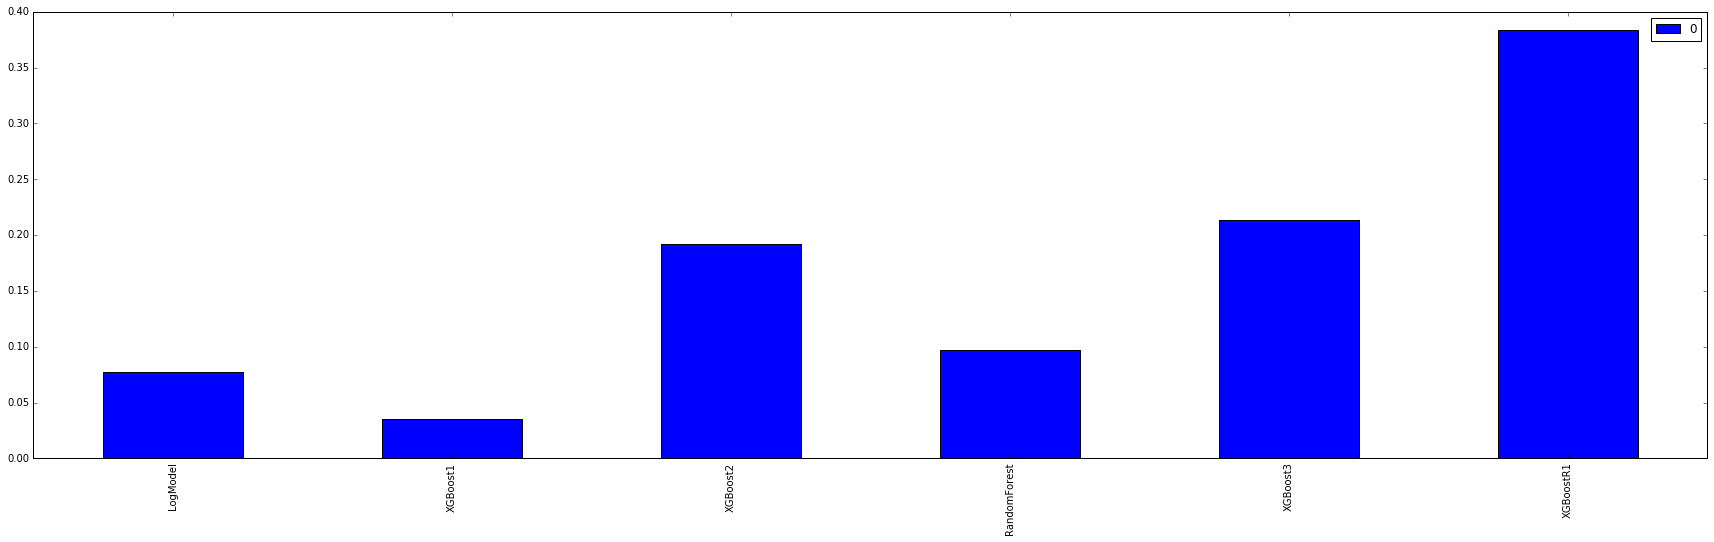

In [49]:
pd.DataFrame(x.feature_importances_, index=stage2_train.columns).plot(kind="bar")

In [52]:
stage2_X_test = stage2_test.ix[:, "LogModel": "XGBoostR1"].values
y_pred = x.predict_proba(stage2_X_test)[:,1]
submission = pd.DataFrame(index=test.index)
submission["TARGET"] = y_pred
submission.to_csv("stack.csv")